In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn import linear_model, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor

np.random.seed(123)

For this project, the goal is to try and predict whether a student is taking paid tutoring with their current circumstances in their student life, represented by the features of the dataset.

In [2]:
data = pd.read_csv('../data/student-mat_cleaned.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      357 non-null    object
 1   sex         357 non-null    object
 2   age         357 non-null    int64 
 3   address     357 non-null    object
 4   famsize     357 non-null    object
 5   Pstatus     357 non-null    object
 6   Medu        357 non-null    int64 
 7   Fedu        357 non-null    int64 
 8   Mjob        357 non-null    object
 9   Fjob        357 non-null    object
 10  reason      357 non-null    object
 11  guardian    357 non-null    object
 12  traveltime  357 non-null    int64 
 13  studytime   357 non-null    int64 
 14  failures    357 non-null    int64 
 15  schoolsup   357 non-null    object
 16  famsup      357 non-null    object
 17  paid        357 non-null    object
 18  activities  357 non-null    object
 19  nursery     357 non-null    object
 20  higher    

In [27]:
#Drop unnecessary columns
#unnecessary_cols = []
unnecessary_cols = ['sex', 'guardian', 'Pstatus', 'school', 'address', 'nursery', 'famsize', 'Mjob', 'Fjob', 
                    'higher', 'internet', 'traveltime']
data_clean = data.drop(columns=unnecessary_cols)

The above features are dropped to stop overfitting because they are deemed to be irrelevant factors in determining whether a student is taking tutoring in this dataset due to either having an inbalanced distribution or having little to no feature importance.

In [4]:
#Converting classification features using one-hot encoding to prepare them for the train/test split
df = pd.get_dummies(data_clean.drop('paid', axis=1))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                357 non-null    int64
 1   Medu               357 non-null    int64
 2   Fedu               357 non-null    int64
 3   studytime          357 non-null    int64
 4   failures           357 non-null    int64
 5   famrel             357 non-null    int64
 6   freetime           357 non-null    int64
 7   goout              357 non-null    int64
 8   Dalc               357 non-null    int64
 9   Walc               357 non-null    int64
 10  health             357 non-null    int64
 11  absences           357 non-null    int64
 12  G1                 357 non-null    int64
 13  G2                 357 non-null    int64
 14  G3                 357 non-null    int64
 15  reason_course      357 non-null    uint8
 16  reason_home        357 non-null    uint8
 17  reason_other    

<AxesSubplot:>

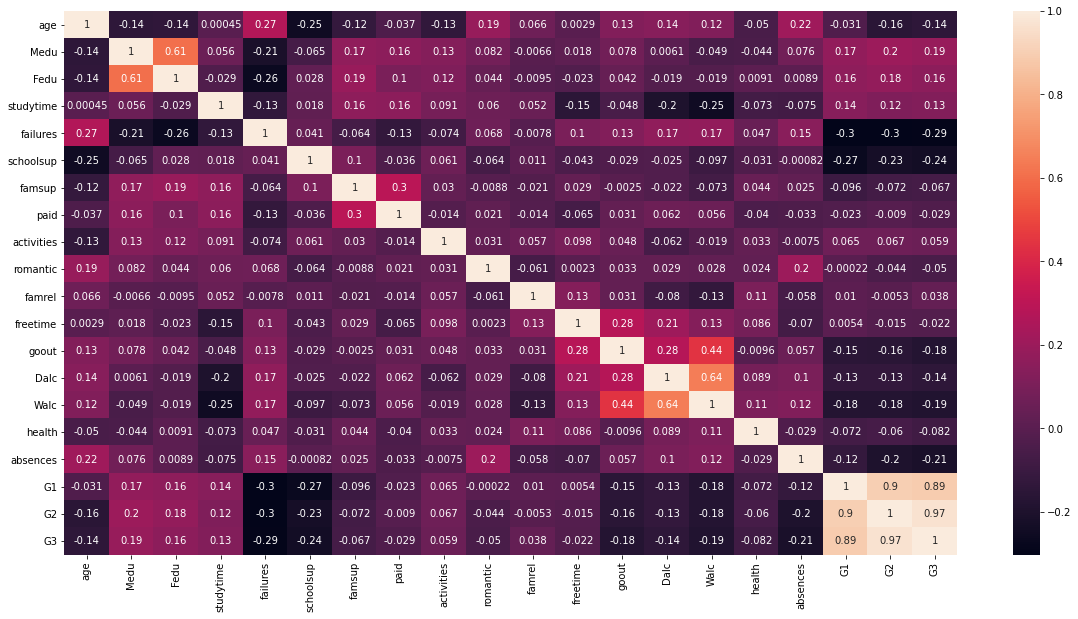

In [5]:
# Make a heatmap of the data
plt.figure(figsize=(20,10))
data2 = data_clean
data2.replace({'yes': 1, 'no': 0}, inplace=True)
sns.heatmap(data2.corr(), annot=True)

**Train/Test Splitting the Data:**

In [6]:
X = df
y = data.paid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

**Modelling**

Since this is a classification problem, the three models that will be used for this project are the Random Forest Classifier, the K-Nearest Neighbors Classifier, and the Gradient Boosting Classifier.

***1. Random Forest***

***1.1 Random Forest Hyperparameter Tuning***

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1, n_jobs=-1)
param_grid = {'n_estimators':np.arange(1,100)}
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv = rf_cv.fit(X_train, y_train)
print(rf_cv.best_estimator_)
print(rf_cv.best_score_)

RandomForestClassifier(n_estimators=68, n_jobs=-1, random_state=1)
0.6439552760307478


***1.2 Random Forest Model Fitting***

In [9]:
rf = RandomForestClassifier(n_estimators=rf_cv.best_estimator_.n_estimators, 
                            n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

rf_ac = accuracy_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred, average='weighted')
rf_ps = precision_score(y_test, rf_y_pred,  pos_label='yes')
rf_rc = recall_score(y_test, rf_y_pred, pos_label='yes')
rf_cv_score = cross_val_score(rf, X_test, y_test, scoring='roc_auc').mean()


print('Random Forest: Accuracy=%.3f' % (rf_ac))
print('Random Forest: f1-score=%.3f' % (rf_f1))
print('Random Forest: Precision=%.3f' % (rf_ps))
print('Random Forest: Recall=%.3f' % (rf_rc))
print('Random Forest: cv score=%.3f' % (rf_cv_score))

Random Forest: Accuracy=0.589
Random Forest: f1-score=0.586
Random Forest: Precision=0.568
Random Forest: Recall=0.500
Random Forest: cv score=0.511


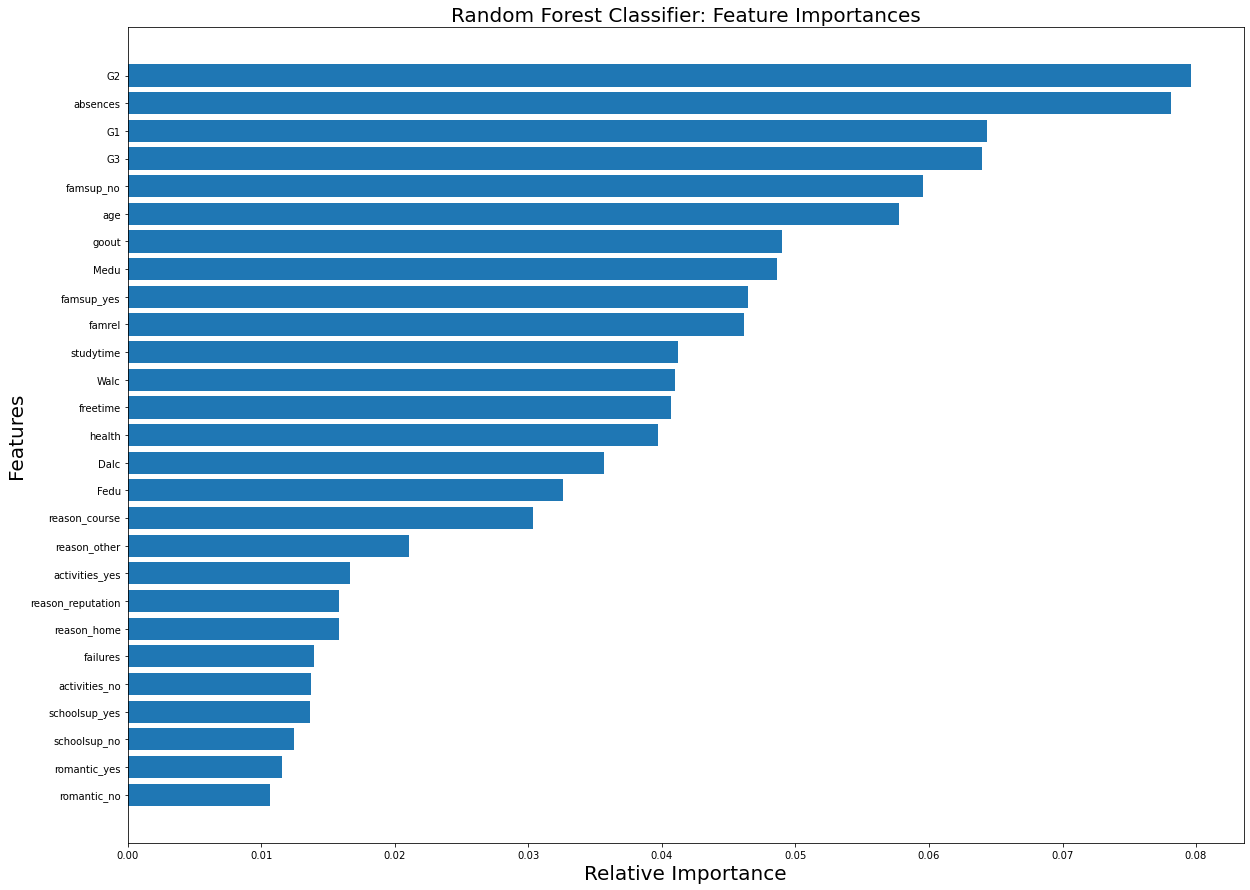

In [10]:
feature_rank = pd.DataFrame(list(zip(X, rf.feature_importances_)), columns=['feature', 'score'])
feature_rank = feature_rank.sort_values(by='score')

plt.figure(figsize=(20, 15))
plt.barh(feature_rank.feature, feature_rank.score)
plt.xlabel('Relative Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Random Forest Classifier: Feature Importances', fontsize=20)

plt.savefig('rf_features.png')

***1.3 Random Forest ROC curve***

In [11]:
rf_y_score = rf.predict_proba(X_test)
rf_y_score = rf_y_score[:,1]
print('ROC-AUC Score:', roc_auc_score(y_test, rf_y_score))

ROC-AUC Score: 0.6455853174603174


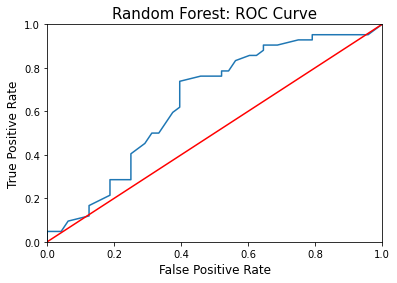

In [12]:
roc_y_test = y_test.replace({'yes': 1, 'no': 0})
rf_false_positive_rate, rf_true_positive_rate, thresholds = roc_curve(roc_y_test, rf_y_score)

plt.plot(rf_false_positive_rate, rf_true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Random Forest: ROC Curve',fontsize=15)
plt.axis([0, 1, 0, 1])
plt.show()

***2. K-Nearest Neighbor***

***2.1 K-Nearest Neighbor Hyperparameter Tuning***

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'n_neighbors':np.arange(10,100)}
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print(knn_cv.best_estimator_)
print(knn_cv.best_score_)

KNeighborsClassifier(n_neighbors=21)
0.704053109713487


***2.2 K-Nearest Neighbor Model Fitting***

In [14]:
knn = KNeighborsClassifier(n_neighbors=knn_cv.best_estimator_.n_neighbors)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

knn_ac = accuracy_score(y_test, knn_y_pred)
knn_f1 = f1_score(y_test, knn_y_pred, average='weighted')
knn_ps = precision_score(y_test, knn_y_pred,  pos_label='yes')
knn_rc = recall_score(y_test, knn_y_pred, pos_label='yes')
knn_cv_score = cross_val_score(knn, X_test, y_test, scoring='roc_auc').mean()

print('KNN: Accuracy=%.3f' % (knn_ac))
print('KNN: f1-score=%.3f' % (knn_f1))
print('KNN: Precision=%.3f' % (knn_ps))
print('KNN: Recall=%.3f' % (knn_rc))
print('KNN: cv score=%.3f' % (knn_cv_score))

KNN: Accuracy=0.689
KNN: f1-score=0.688
KNN: Precision=0.640
KNN: Recall=0.762
KNN: cv score=0.592


***2.3 KNN ROC curve***

In [15]:
knn_y_score = knn.predict_proba(X_test)
knn_y_score = knn_y_score[:,1]
print('ROC-AUC Score:', roc_auc_score(y_test, knn_y_score))

ROC-AUC Score: 0.7291666666666666


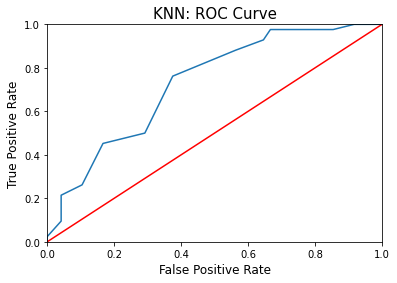

In [16]:
knn_false_positive_rate, knn_true_positive_rate, thresholds = roc_curve(roc_y_test, knn_y_score)

plt.plot(knn_false_positive_rate, knn_true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('KNN: ROC Curve',fontsize=15)
plt.axis([0, 1, 0, 1])
plt.show()

***3. Gradient Boosting***

***3.1 Gradient Boosting Hyperparameter Tuning***

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=1)
param_grid = {'n_estimators':np.arange(1,100)}
gb_cv = GridSearchCV(gb, param_grid, cv=5)
gb_cv = gb_cv.fit(X_train, y_train)
print(gb_cv.best_estimator_)
print(gb_cv.best_score_)

GradientBoostingClassifier(n_estimators=31, random_state=1)
0.6628232005590495


***3.2 Gradient Boosting Model Fitting***

In [18]:
gb = GradientBoostingClassifier(n_estimators=gb_cv.best_estimator_.n_estimators, 
                                random_state=1)
gb.fit(X_train, y_train)
gb_y_pred = gb.predict(X_test)

gb_ac = accuracy_score(y_test, gb_y_pred)
gb_f1 = f1_score(y_test, gb_y_pred, average='weighted')
gb_ps = precision_score(y_test, gb_y_pred,  pos_label='yes')
gb_rc = recall_score(y_test, gb_y_pred, pos_label='yes')
gb_cv_score = cross_val_score(gb, X_test, y_test, scoring='roc_auc').mean()

print('Gradient Boosting: Accuracy=%.3f' % (gb_ac))
print('Gradient Boosting: f1-score=%.3f' % (gb_f1))
print('Gradient Boosting: Precision=%.3f' % (gb_ps))
print('Gradient Boosting: Recall=%.3f' % (gb_rc))
print('Gradient Boosting: cv score=%.3f' % (gb_cv_score))

Gradient Boosting: Accuracy=0.667
Gradient Boosting: f1-score=0.667
Gradient Boosting: Precision=0.630
Gradient Boosting: Recall=0.690
Gradient Boosting: cv score=0.483


Text(0.5, 1.0, 'Gradient Boosting Classifier: Feature Importances')

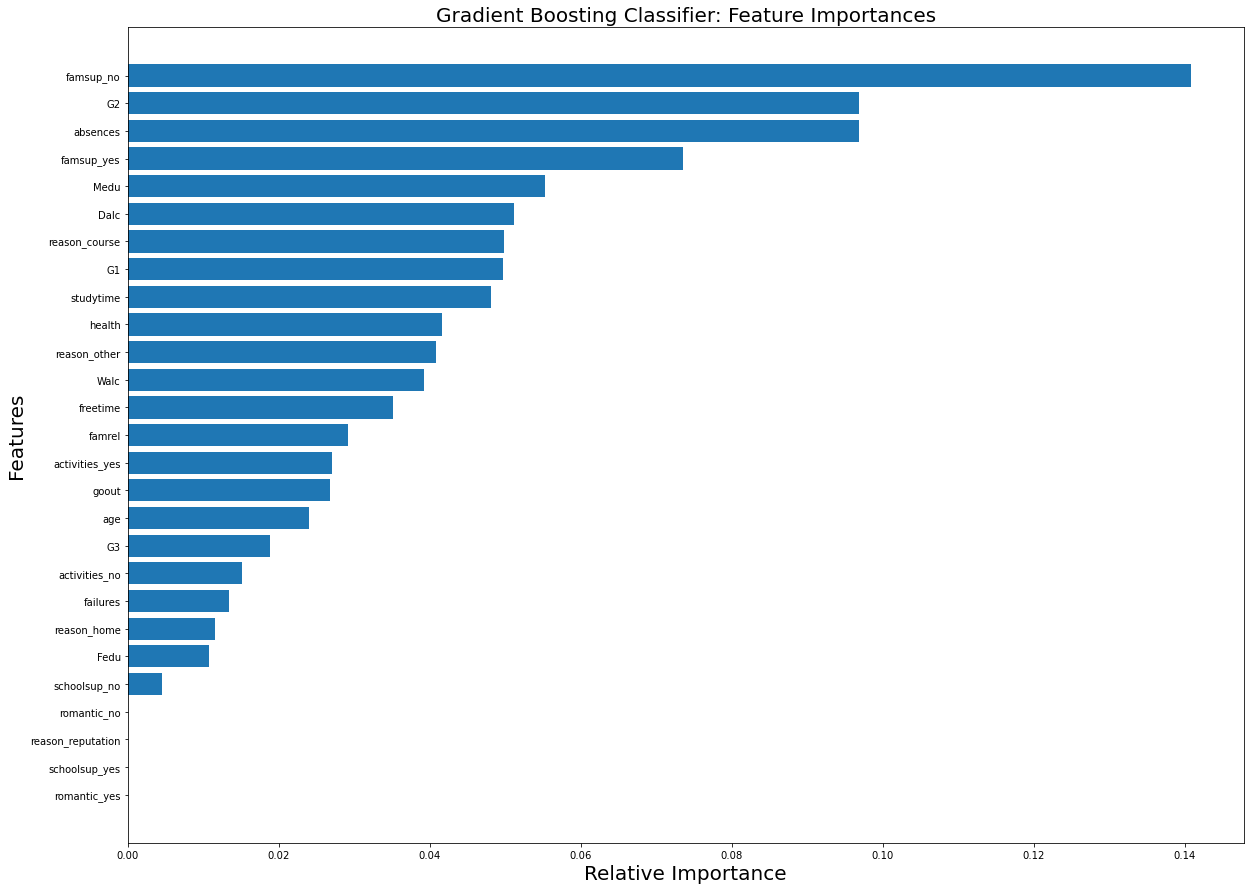

In [19]:
feature_rank = pd.DataFrame(list(zip(X, gb.feature_importances_)), columns=['feature', 'score'])
feature_rank = feature_rank.sort_values(by='score')

plt.figure(figsize=(20, 15))
plt.barh(feature_rank.feature, feature_rank.score)
plt.xlabel('Relative Importance', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Gradient Boosting Classifier: Feature Importances', fontsize=20)

***3.3 Gradient Boosting ROC curve***

In [20]:
gb_y_score = gb.predict_proba(X_test)
gb_y_score = gb_y_score[:,1]
print('ROC-AUC Score:', roc_auc_score(y_test, gb_y_score))

ROC-AUC Score: 0.6557539682539683


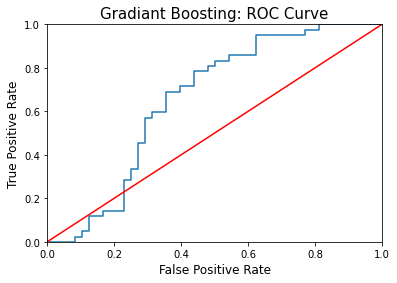

In [21]:
gb_false_positive_rate, gb_true_positive_rate, thresholds = roc_curve(roc_y_test, gb_y_score)

plt.plot(gb_false_positive_rate, gb_true_positive_rate)
plt.plot([0, 1], [0, 1], 'r')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Gradiant Boosting: ROC Curve',fontsize=15)
plt.axis([0, 1, 0, 1])
plt.show()

In [22]:
#Comparing the scores among the three methods
scores_index = ['Accuracy', 'F1', 'Precision', 'Recall', 'CV', 'ROC-AUC']
rf_scores = [rf_ac, rf_f1, rf_ps, rf_rc, rf_cv_score, roc_auc_score(y_test, rf_y_score)]
knn_scores = [knn_ac, knn_f1, knn_ps, knn_rc, knn_cv_score, roc_auc_score(y_test, knn_y_score)]
gb_scores = [gb_ac, gb_f1, gb_ps, gb_rc, gb_cv_score, roc_auc_score(y_test, gb_y_score)]

scores_table = pd.DataFrame({'Random Forest': rf_scores, 'KNN': knn_scores, 'Gradient Boosting':gb_scores},
                           index=scores_index)
scores_table

,Random Forest,KNN,Gradient Boosting
Accuracy,0.588889,0.688889,0.666667
F1,0.586055,0.688274,0.666996
Precision,0.567568,0.640000,0.630435
Recall,0.500000,0.761905,0.690476
CV,0.511435,0.592346,0.482870
ROC-AUC,0.645585,0.729167,0.655754


From the above table, we can see that the KNN classifier performs the best in all aspects!

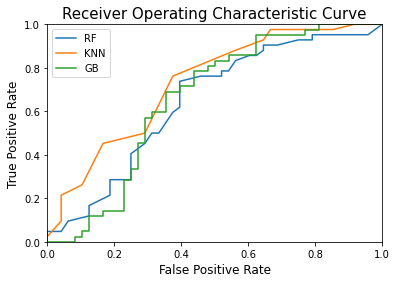

In [23]:
#Plot all roc curves in one plot

plt.plot(rf_false_positive_rate, rf_true_positive_rate, label='RF')
plt.plot(knn_false_positive_rate, knn_true_positive_rate, label='KNN')
plt.plot(gb_false_positive_rate, gb_true_positive_rate, label='GB')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic Curve', fontsize=15)
plt.legend()
plt.axis([0, 1, 0, 1])
plt.show()

From the ROC curve, it shows that KNN clearly has the overall best curve! 

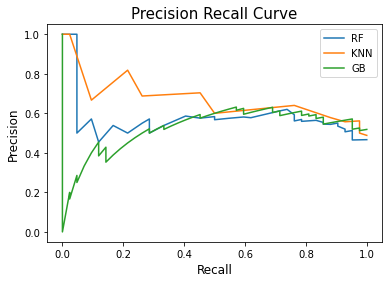

In [25]:
#Plot Precision Recall Curve

rf_precision, rf_recall, rf_thresholds = precision_recall_curve(roc_y_test, rf_y_score)
plt.plot(rf_recall, rf_precision, label='RF')

knn_precision, knn_recall, knn_thresholds = precision_recall_curve(roc_y_test, knn_y_score)
plt.plot(knn_recall, knn_precision, label='KNN')

gb_precision, gb_recall, gb_thresholds = precision_recall_curve(roc_y_test, gb_y_score)
plt.plot(gb_recall, gb_precision, label='GB')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Recall Curve', fontsize=15)
plt.legend(loc="upper right")
plt.show()

From the precision-recall curve, it also shows that KNN performs the best among the three!

Overall, from these results, we can conclude that KNN is the best performing model among the three!